# Cymr 

Cymr is a python library (developed by Sean Polyn and Neale Morton) that contains code to implement the CMR model of memory retrieval. Let's take a look at what code this library has to offer!

In [40]:
import cymr

# FIXME: Add visualization of the weight of CMR network after reading 20 sentences
## Each node is a circle at a point, and create functions to draw lines of varying opacities between two points
## Then use the weight matrix to add those lines and cricles

`Note:` The two big questions I am hoping to find out are:

1. How can I find the best parameters for CMR (to describe patterns in the data)?
2. How can I simulate the free recall process using an implentation of the CMR model?

# (0) Load In Data

Here we store our complete recall data in `our_df` and CMR-formmated data in `our_data`.

In [48]:
import pandas as pd
from cymr import fit, cmr
import numpy as np

our_df = pd.read_csv("C:/Summer 2023 - DSI-SRP/featureFR/Recall Analysis/data/psifr_al1_sl.csv")

def assign_item_number(story_list: str, passage: int, item: int):
    """Assign item number based on story_list, passage, and item of the sentence.

    Args:
        story_list (str): e.g. 'A',
        passage (int): e.g. 1
        item (int): e.g. 0
    """
    item_number = 100*(ord(story_list) - ord('A'))  + 20*(passage - 1) + item
    return item_number

assign_item_number(story_list="B",passage=1,item=1)

# (1.2) Add item numbers to dataframe
story_list_col = our_df.story_list.to_list()
passage_col = our_df.passage.to_list()
item = our_df.item.to_list()

item_numbers = [assign_item_number(story_list_col[i], passage_col[i], item[i]) for i in range(len(our_df))]
our_df["item_index"]  = item_numbers
our_df.head(1)

# (1.3) Format Data
cmr_columns = ['subject', 'list', 'position', 'trial_type', 'item', 'item_index']
data_lst = []

for index, row in our_df.iterrows():
    if row["study"]:
        study_item = [
            row["subject"],
            row["list"],
            row["input"],
            "study",
            row["item_string"],
            row["item_index"]
        ]
        data_lst.append(study_item)
    if row["recall"]:
        recall_item = [
            row["subject"],
            row["list"],
            int(row["output"]),
            "recall",
            row["item_string"],
            row["item_index"]
        ]
        data_lst.append(recall_item)
        
our_data = pd.DataFrame(data_lst, 
                           columns = cmr_columns).sort_values(["subject", "list", "trial_type", "position"], 
                                                              ascending=[True, True, False, True],
                                                              ignore_index=True)
print(len(our_data))
our_data.head(1)

2226


,subject,list,position,trial_type,item,item_index
0,0,0,1,study,Smaller and larger abscesses may require diffe...,0


# (0.5) Evaluating a Model

##### **Example:**

In [10]:
# (0) Loading in data 
from cymr import fit, cmr
data = fit.sample_data('Morton2013_mixed')
data = data[["subject", "list", "position", "trial_type", "item", "item_index"]]
data.head()
print(len(data))

31754


In this sample data, each trial consists of people studying 24 items (photos of celebrities, objects, or locations), and then trying to remember as many of those items in any order. 
* This comes from a [2013 study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3767960/) where a classifier was trained to predict the category of object a person was looking at based on oscillations in brain activity (measured by an EEG). 
  * The big question this research study is "are there detectable neural signals that correpsond to a context-based retrieval cue, such as the category of an object?" If here is then you should be able to spot these neural signals and use them to predict when a participant is going to recall an picture of the same type as the previous picture
  * Recall that the CMR model says that people create a representation of time that items are tied to, which is then used as a retrieval-cue. This study adds to the model by suggesting people create category-based retrieval cues.

In [11]:
# (1) Example of a trial
data.query("subject == 1 and list == 4")
# data.query("item_index == 0")

,subject,list,position,trial_type,item,item_index
80,1,4,1,study,BRANDENBURG GATE,278
81,1,4,2,study,JENNE MOSQUE,353
82,1,4,3,study,USHER,247
83,1,4,4,study,NEWT GINGRICH,190
84,1,4,5,study,TOMATO,740
85,1,4,6,study,MICROSCOPE,651
86,1,4,7,study,ELIZABETH TAYLOR,84
87,1,4,8,study,FAITH HILL,87
88,1,4,9,study,BILLY CRYSTAL,34
89,1,4,10,study,MOUNT KILIMANJARO,395


In [12]:
# (2) Associate each studied item with a pattern in the network 
n_items = 768       # 256 of each type of object
loc_patterns = np.eye(n_items)
loc_patterns

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
# (3) Grab studied items
study = data.query("trial_type == 'study'")
items = study.groupby('item_index')['item'].first().to_numpy()      # List of all the study items, based on their item index
patterns = {'items': items, 'vector': {'loc': loc_patterns}}        # List of items and patterns they correspond to
patterns


{'items': array(['ABRAHAM LINCOLN', 'ADAM SANDLER', 'AL GORE', 'AL PACINO',
        'AL SHARPTON', 'ALBERT EINSTEIN', 'ALEC BALDWIN', 'ALEX RODRIGUEZ',
        'ALEX TREBEK', 'ALICIA KEYS', 'ALLEN IVERSON', 'ANDRE3000',
        'ANDRE AGASSI', 'ANGELINA JOLIE', 'ANNETTE BENING',
        'ANTHONY HOPKINS', 'ANTONIO BANDERAS', 'ARNOLD SCHWARZENEGGER',
        'ASHTON KUTCHER', 'AUDREY HEPBURN', 'AUDREY TATOU', 'BABE RUTH',
        'BARBARA WALTERS', 'BARRY BONDS', 'BEN KINGSLEY', 'BEN STILLER',
        'BENICIO DEL TORO', 'BENJAMIN FRANKLIN', 'BILL CLINTON',
        'BILL COSBY', 'BILL GATES', 'BILL MAHER', 'BILL MURRAY',
        'BILLY BOB THORNTON', 'BILLY CRYSTAL', 'BOB DOLE', 'BOB DYLAN',
        'BOB SAGET', 'BONO', 'BRAD PITT', 'BRITNEY SPEARS',
        'BRITTANY MURPHY', 'BRUCE LEE', 'BRUCE SPRINGSTEEN',
        'BRUCE WILLIS', 'CAMERON DIAZ', 'CARROT TOP', 'CARY GRANT',
        'CATHERINE ZETA JONES', 'CHARLIE SHEEN', 'CHARLIZE THERON',
        'CHE GUEVARA', 'CHER', 'CHRIS FARLE

Parameters
* What is the difference between a sublayer and a segment of the `f` and `c` layers?
* What does the `w_loc` parameter do?

In [14]:
## (4) Define Parameters
param_def = cmr.CMRParameters()

param_def.set_sublayers(f=['task'], c=['task'])

# weight format
## tuple of tuples: ( (feature_sublayer, feature_segment),  (context_sublayer, context_segment)     :   'expression for weights')
weights = {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}

param_def.set_weights(connect='fc', regions=weights)

param_def.set_weights(connect='cf', regions=weights)

print(param_def)


fixed:


free:


dependent:


dynamic:


sublayers:
f: ['task']
c: ['task']

weights:
fc: {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}
cf: {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}

sublayer_param:



Here we set the weights so that each feature neuron is only connected to the one context neuron with a weight of one 
* This is because `w_loc` = 1, `loc` = identity matrix

In [15]:
# Dictionary of parameters
param = {
    'B_enc': 0.7,
    'B_start': 0.3,
    'B_rec': 0.9,
    'w_loc': 1,
    'Lfc': 0.15,
    'Lcf': 0.15,
    'P1': 0.2,
    'P2': 2,
    'T': 0.1,
    'X1': 0.001,
    'X2': 0.25
}

Evaluting a model using log likelihood
* Log likelihood is the logarithm of the generated probability of a particular participant's recall sequence 
* The largest log likehood a recall sequence can have is 0 (log(1) = 0)

In [16]:
model = cmr.CMR()

results = model.likelihood(data, param, param_def=param_def, patterns=patterns)

results

,logl,n
subject,,
1,-954.986639,373
2,-1112.451759,426
3,-983.992163,379
5,-1273.049983,517
8,-867.828568,320
11,-1109.605775,412
16,-738.307772,297
18,-1114.587857,403
22,-1040.643977,378


##### **Our Data**:

In [17]:
# (1) Load in Data
our_data.head(1)

,subject,list,position,trial_type,item,item_index
0,0,0,1,study,Smaller and larger abscesses may require diffe...,0


In [18]:
# (2) Associate each studied item with a pattern in the network 
import numpy as np

n_items = our_data.item_index.max() + 1
print(n_items)       
loc_patterns = np.eye(n_items)
loc_patterns

80


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
# (3) Associate each sentence with a pattern
items = our_data.groupby('item_index')['item'].first().to_numpy()      # List of all the study items, based on their item index
patterns = {'items': items, 'vector': {'loc': loc_patterns}}        # List of items and patterns they correspond to
patterns

{'items': array(['Smaller and larger abscesses may require different methods for treatment.',
        'Smaller abscesses are typically less than five millimeters wide.',
        'Applying warm soaks can promote pus straining in smaller abscesses.',
        'Larger abscesses will require an incision to strain them.',
        'Signs of larger abscesses include increased inflammation and pus collection.',
        'Ensure the appropriate precautions are met before treating the patient.',
        'Gather all necessary equipment required to care for the abscess.',
        'Position the patient so the abscess is easily accessible.',
        'Surround the abscess with cleaned drapes and cover adjacent areas.',
        'Lastly, apply anesthesia to the edge surrounding the abscess.',
        'Once required preparations are complete, perform the incision and strainage.',
        'Insert the syringe slightly under the skin to inject anesthetic.',
        'Next, cut open the abscess and strain out 

In [20]:
## (4) Set Parameters
param_def = cmr.CMRParameters()
param_def.set_sublayers(f=['task'], c=['task'])
weights = {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}
param_def.set_weights(connect='fc', regions=weights)
param_def.set_weights(connect='cf', regions=weights)
param = {'B_enc': 0.7, 'B_start': 0.3, 'B_rec': 0.9, 'w_loc': 1, 'Lfc': 0.15, 'Lcf': 0.15, 'P1': 0.2, 'P2': 2, 'T': 0.1, 'X1': 0.001, 'X2': 0.25
}
print(param_def)


fixed:


free:


dependent:


dynamic:


sublayers:
f: ['task']
c: ['task']

weights:
fc: {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}
cf: {(('task', 'item'), ('task', 'item')): 'w_loc * loc'}

sublayer_param:



In [21]:
# (5) Use model to evaluate likelihood of free recall data
model = cmr.CMR()
results = model.likelihood(our_data, param, param_def=param_def, patterns=patterns)
results

,logl,n
subject,,
0,-152.810677,43
1,-128.119155,31
2,-140.954833,35
3,-175.773679,60
4,-159.140012,43
5,-148.126789,38
6,-153.090002,37
7,-152.429836,56
8,-163.047069,52


Let's check out the participants whose recalls had super low probabilities for their recall sequence (as there might be an error in scoring)
* AL1005 
* AL1013 
* AL1018 
* AL1025 

# (1) Fitting a Model

The CMR model is a neural network has three parts:
1. One layer that encodes events, each neuron representing a feature of the event
2. One layer that encodes contexts, each neuron representing a particular time or situation
3. Weighted connections two layers, each connection tells us how much an event is tied to a context (particular time or situation )

It also has three rules that govern its behavior:
1. Context Reinstatement (`f_i -> c_i`) -- How remembering an event causes you to remember it's context 
2. Associations between Layers (`f_i, c_i -> M^FC`) -- How are events associated with contexts?  -- `Hebbian Learning Rule "Neurons that fire together wire together"`
1. Retrieval Competion (`c_i -> f_i`) -- How context is used as a retrieval cue (an aid to remember events)

##### **Example:**

In [22]:
# (0) Load in free recall data -- this particular free recall study participants looked at pictures of people, places, and objects,
from cymr import fit, cmr
data = fit.sample_data('Morton2013_mixed')
data.head()

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category
0,1,2,1,study,SEAN PENN,228,1,mixed,cel,3.0,1.255,mixed
1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,3.0,1.040,mixed
2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,2.0,1.164,mixed
3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,2.0,0.829,mixed
4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,3.0,0.872,mixed


A CMR model is defined parameters (variables that control how the model behaves).
* Beta_encoding = How much recalling an item changes the current context (contextual re-instatement)
* Gamma () = Controls the degree of forward asymmetry
* Phi = Controls primacy effect

In [23]:
# (1) Define a set of Parameters for the Model along with pre-experimental weights
par = cmr.CMRParameters()

par.set_fixed(T=0.1, Lfc=0.15, Lcf=0.15, P1=0.2, P2=2,
              B_start=0.3, B_rec=0.9, X1=0.001, X2=0.25)


par.set_free(B_enc=(0, 1))

par.set_dependent(Dfc='1 - Lfc', Dcf='1 - Lcf')

n_items = 768

study = data.query("trial_type == 'study'")

items = study.groupby('item_index')['item'].first().to_numpy()

patterns = {'items': items, 'vector': {'loc': np.eye(n_items)}}

par.set_sublayers(f=['task'], c=['task'])

weights = {(('task', 'item'), ('task', 'item')): 'loc'}

par.set_weights('fc', weights)

par.set_weights('cf', weights)
# We cans save a set of parameters into a JSON file
# par.to_json('parameters.json')

# restored = cmr.read_config('parameters.json')

In [24]:
# (2) Create Model using Parameters
model = cmr.CMR()
results = model.fit_indiv(data, par, patterns=patterns, tol=0.1)
best = fit.get_best_results(results)

# logl = logarithm of the probability of the participant's recall sequence according to the model
# k = number of free parameters
# best[['B_enc', 'logl', 'n', 'k']].head(5)
best.head()

,rep,T,Lfc,Lcf,P1,P2,B_start,B_rec,X1,X2,B_enc,Dfc,Dcf,logl,n,k
subject,,,,,,,,,,,,,,,,
1,0,0.1,0.15,0.15,0.2,2.0,0.3,0.9,0.001,0.25,0.693528,0.85,0.85,-954.976072,373,1
2,0,0.1,0.15,0.15,0.2,2.0,0.3,0.9,0.001,0.25,0.615342,0.85,0.85,-1109.066717,426,1
3,0,0.1,0.15,0.15,0.2,2.0,0.3,0.9,0.001,0.25,0.743079,0.85,0.85,-983.635155,379,1
5,0,0.1,0.15,0.15,0.2,2.0,0.3,0.9,0.001,0.25,0.577965,0.85,0.85,-1264.186512,517,1
8,0,0.1,0.15,0.15,0.2,2.0,0.3,0.9,0.001,0.25,0.627175,0.85,0.85,-866.701444,320,1


##### **Our Data:**

Let's look at the parameters of the model, and see which one we might want to search for or set:

**Search For:**
* `Lfc` and `Lcf`:  learning rate for the weights between layers   (0 - 1)
* `B_enc`:    integration rate during studying      (0 - 1)
* `B_start` : integration rate at the start of remembering  (0 - 1)
* `B_rec`:    integration rate during recall    (0 - 1)
* `P1`:       Additional context item strength for first item  (0 - 1)
* `P2`:       Decay weight for primacy learning gradient (??)
* `X2`:       Determines exponential function that describes probability of stopping by output position (0 - 1)
  * Smaller value, more people remember

**Set:**
* `X1`: probability of not recalling any items (can manually calculate this when we include phone calls)



---

**Parameters**

* Learning: Learning Rates (Lfc and Lcf), Primacy effect parameters (P1 and P2)

* Integration: How much the activity in `f` layer integrated into `c` layer (B_enc, B_start, B_rec)

* End of Recall: X1 and X2

**Parameter Defintion Object:** is used to manage parameters. It defines the structure of the network (weight and sublayers and segments), and along ranges of acceptable parameter values.

In [44]:
# (0) Calculate the probability of not remembering anything
our_data.head()
groupby_columns = ["subject", "list"]
num_empty_recalls = 0 
for trial_index, trial in enumerate(our_data.groupby(groupby_columns)):
    trial = trial[1]
    if len(trial) ==  trial.trial_type.value_counts()["study"]:    # IF participant does not recall anything
        num_empty_recalls += 1

prob_not_recalling_anything = num_empty_recalls / trial_index
prob_not_recalling_anything


0.0

In [45]:
import numpy as np 
## (1.1) Create a parameter object (represents the parameters of a CMR model)
par = cmr.CMRParameters()
par.set_fixed(T=0.1, X1=prob_not_recalling_anything)
par.set_free(B_enc=(0.01, .999), 
             B_start=(0.01, .999), 
             B_rec=(0.01, .999), 
             X2=(0.01, .999), 
             Lfc=(0.01, .999), 
             Lcf=(0.01, .999),
             P1=(0.01, .999),
             P2=(0.5, 4))

par.set_dependent(Dfc='1 - Lfc', Dcf='1 - Lcf')

## (1.2) Grab all the studied items and associate them with a pattern in the model
n_items = our_data.item_index.max() + 1
loc_patterns = np.eye(n_items)
items = our_data.groupby('item_index')['item'].first().to_numpy()      # List of all the study items, based on their item index
patterns = {'items': items, 'vector': {'loc': loc_patterns}}        # List of items and patterns they correspond to

# (1.3) Set up the weights connecting the two layers of the model
par.set_sublayers(f=['task'], c=['task'])
weights = {(('task', 'item'), ('task', 'item')): 'loc'}
par.set_weights('fc', weights)
par.set_weights('cf', weights)
# print(par)

In [47]:
# (2) Create Model using Parameters
model = cmr.CMR()
results = model.fit_indiv(our_data, par, patterns=patterns, tol=0.05, n_rep=1)
best = fit.get_best_results(results)
# logl = logarithm of the probability of the participant's recall sequence according to the model
# k = number of free parameters
# n = number of data points (tested before found acceptable fit)
best

NameError: name 'fit' is not defined

**Trouble-shooting**
It looks like the beta encoding rates are super small. Why is that? 
* Maybe it's because we don't have enough data to fit the model? To test this, let's combine all the free recall data into one participant.

It was not because we didn't have enough data, but rather because we didn't search the parameter space and that caused the model to act super funky. 
* All the parameters work together to create the behavior of this model. If one parameter is significantly off for the model, that will push other parameters off to account for that gap.

###### Troubleshooting

In [ ]:
# TROUBLE SHOOTING
# (0) Combine all the recall data into one participant
# test_enc_rate_df = our_data.copy()
# num_passages_upper_bound = our_data.list.max() + 1
# new_lst_index = [ (num_passages_upper_bound*subject) + lst for subject,lst in zip(our_data.subject, our_data.list)]
# test_enc_rate_df["list"] = new_lst_index        # Created a list index so there are no collisions
# test_enc_rate_df["subject"] = 0
# test_enc_rate_df

# from psifr import fr
# crps = fr.lag_crp(fr.merge_free_recall(our_data))
# fr.plot_lag_crp(crps)

Now we can use the parameters we found to generate free recall data.

# (2) Generating Simulated Data

##### **Example:**

In [29]:
# (0) Load in data
from cymr import fit, cmr

from psifr import fr

data = fit.sample_data('Morton2013_mixed')

items = (data
    .query('trial_type == "study"')
    .groupby('item_index')
    .first()['item']
    .to_numpy()
)

data = fr.filter_data(data, subjects=1)

fr.filter_data(data, trial_type='study')

,subject,list,position,trial_type,item,item_index,session,list_type,category,response,response_time,list_category
0,1,2,1,study,SEAN PENN,228,1,mixed,cel,3.0,1.255,mixed
1,1,2,2,study,AUDREY HEPBURN,19,1,mixed,cel,3.0,1.040,mixed
2,1,2,3,study,ST PATRICKS CATHEDRAL,463,1,mixed,loc,2.0,1.164,mixed
3,1,2,4,study,LES INVALIDES,364,1,mixed,loc,2.0,0.829,mixed
4,1,2,5,study,GREAT ZIMBABWE RUINS,340,1,mixed,loc,3.0,0.872,mixed
...,...,...,...,...,...,...,...,...,...,...,...,...
1062,1,48,20,study,CHE GUEVARA,51,3,mixed,cel,3.0,0.641,mixed
1063,1,48,21,study,OAHU BEACH,406,3,mixed,loc,3.0,0.997,mixed
1064,1,48,22,study,GATEWAY ARCH,324,3,mixed,loc,2.0,0.589,mixed
1065,1,48,23,study,WHITE HOUSE,501,3,mixed,loc,3.0,0.733,mixed


In [30]:
# (1) Define the parameters of our model
param = {
    'B_enc': 0.6,
    'B_start': 0.3,
    'B_rec': 0.8,
    'Afc': 0,
    'Dfc': 0.85,
    'Acf': 1,
    'Dcf': 0.85,
    'Aff': 0,
    'Dff': 1,
    'Lfc': 0.15,
    'Lcf': 0.15,
    'P1': 0.8,
    'P2': 1,
    'T': 0.1,
    'X1': 0.001,
    'X2': 0.35
}

patterns = {'items': items, 'vector': {'loc': np.eye(768)}}

param_def = cmr.CMRParameters()

param_def.set_sublayers(f=['task'], c=['task'])

weights = {(('task', 'item'), ('task', 'item')): 'loc'}

param_def.set_weights('fc', weights)

param_def.set_weights('cf', weights)

In [31]:
#  (2) Simulate free recall sessions using the model, and score them
model = cmr.CMR()
sim = model.generate(data, param, param_def=param_def, patterns=patterns, n_rep=5)
sim.head(1)

sim_data = fr.merge_free_recall(sim)
sim_data.head(1)

,subject,list,item,input,output,study,recall,repeat,intrusion,prior_list,prior_input
0,1,2,SEAN PENN,1,12.0,True,True,0,False,NaN,NaN


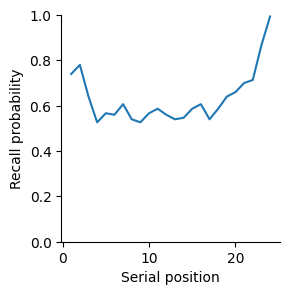

In [32]:
recall = fr.spc(sim_data)

g = fr.plot_spc(recall)

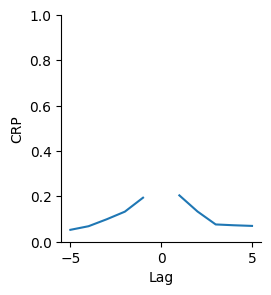

In [33]:
crp = fr.lag_crp(sim_data)

g = fr.plot_lag_crp(crp)

# Network Module

The network module of cymr contains code that implement the CMR model on a low-level, in terms of activations in two layers and the weights between them. This looks like the perfect level of abstraction to start modifying the model.

Note that in term of structure of the model we have
* layers = {'f', 'c'}
* sublayers = e.x.{'location', 'category'}  -- the reason is to be able to set different parameters for different sublayers
* segments = e.g. {item}
* units = Each individual neuron

Why are there both sublayers and segments? Why break apart so much?

In [26]:
from cymr import network

n_items = our_data.item_index.max() + 1

f_segment = {'f_layer': {'f_segment': n_items}}
c_segment = {'c_layer': {'c_segment': n_items}}

net = network.Network(f_segment, c_segment)

print(net)
print("Context:", net.c)
print("Features:", net.f)
print("\n Here are the names we gave to each part of the network (used for index) and changing parameters and weights to only specific parts of the network")
print(net.f_sublayers)
print(net.c_sublayers)
print(net.f_segment)
print(net.c_segment)
print("\nActivation of the first unit:", net.get_unit('f', 'f_layer', 'f_segment', 0))
print("Pre-experimental connections between each neuron representing an event:", net.w_ff_pre.shape)
print("Associations between items and context", net.w_cf_exp.shape,net.w_fc_exp)

f:
f_layer: 80 units
    f_segment: 80 units

c:
c_layer: 80 units
    c_segment: 80 units

Context: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]

 Here are the names we gave to each part of the network (used for index) and changing parameters and weights to only specific parts of the network
['f_layer']
['c_layer']
{'f_layer': {'f_segment': 80}}
{'c_layer': {'c_segment': 80}}

Activation of the first unit: 0
Pre-experimental connections between each neuron representing an event: (80, 80)
Associations between items and context (80, 80) [[0

Say we have 24 items we want to represent, and we want to associate each of them with a category. Then  we can create these weight as follows.

In [39]:
# (1) Create the network
from cymr import network

f_segment = {'task': {'item': 24}}
c_segment = {
    'loc': {'item': 24},
    'cat': {'item': 3},
}

net = network.Network(f_segment, c_segment)

print(net)

# (2) We can set the weights in the network manually 
import numpy as np

cat = np.zeros((24, 3))
cat[:8, 0] = 1
cat[8:16, 1] = 1
cat[16:, 2] = 1

# and can save these patterns in a dictionary
patterns = {
    'vector': {
        'loc': np.eye(24),
        'cat': cat,
    },
}
# cat

f:
task: 24 units
    item: 24 units

c:
loc: 24 units
    item: 24 units
cat: 3 units
    item: 3 units



In [37]:
# (2) Define the pre-experimental weights of the network
from cymr import cmr

param_def = cmr.CMRParameters()
param_def.set_sublayers(f=['task'], c=['loc', 'cat'])
weights = {
    (('task', 'item'), ('loc', 'item')): 'loc',
    (('task', 'item'), ('cat', 'item')): 'cat',
}
param_def.set_weights('fc', weights)
param_def.set_weights('cf', weights)

print(param_def)

fixed:


free:


dependent:


dynamic:


sublayers:
f: ['task']
c: ['loc', 'cat']

weights:
fc: {(('task', 'item'), ('loc', 'item')): 'loc', (('task', 'item'), ('cat', 'item')): 'cat'}
cf: {(('task', 'item'), ('loc', 'item')): 'loc', (('task', 'item'), ('cat', 'item')): 'cat'}

sublayer_param:

